In [1]:
import sys
sys.path.append('/Users/gary/anaconda/lib/python2.7/site-packages')

In [2]:
%matplotlib inline
from matplotlib.pyplot import *

In [3]:
import numpy as np
X = np.random.random((1000, 3))

T initial =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.]
Tau and T_final = 0.327 [ 1.          0.99218968  0.98457167  0.97733356  0.97065357  0.96469619
  0.9596081   0.9555146   0.95251648  0.95068755  0.95007287  0.95068755
  0.95251648  0.9555146   0.9596081   0.96469619  0.97065357  0.97733356
  0.98457167  0.99218968  1.        ]


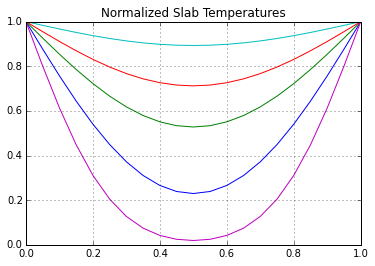

In [16]:
#========================================================================
# Example 7.1 Carnahan, Luther and Wilkes, "Applied Numerical Methods"
# pg.434
# Unsteady-State Heat Conduction in an Infinite, Parellel-Sided Slab
# Solved using an explicit method
#========================================================================
#Import Packages for Solution
#========================================================================
from scipy import *
from pylab import *
from matplotlib import *
#========================================================================
#Input constants
#========================================================================
dtau = 0.001 # Set dimensionless time increments
dx = 0.05    # Set dimensionless length increments
Tmax = 0.95  # Set maximum dimensionless temperature
M = 21       # Counter for length discretization
#========================================================================
#Calculate parameters
#========================================================================
dx = 1.0/(M-1)
dx_x = 1.0/(M-1)
ratio = dtau/(dx**2)
const = 1.0 - 2.0*ratio
#========================================================================
#Set counters to zero
#========================================================================
i = 0
tau = 0.0
#========================================================================
# Set up arrays for solution and print
#========================================================================
Tnew = zeros(M, dtype = float)
T = zeros(M, dtype = float)
T[0] = 1.0
T[-1] = 1.0
print "T initial = ", T
#========================================================================
# I just pick 400 on trial and error for the total array
#========================================================================
T_sol = zeros((400,M), dtype = float)
T_sol[:,0] = 1.0
T_sol[:,-1] = 1.0
#========================================================================
# While loop to iterate until mid-point temperature reaches Tmax
#========================================================================
while T[10] < Tmax:
    i = i + 1
    tau = tau + dtau
#========================================================================
# Calculate new tempertures
#========================================================================
    for j in range(1,M-1):
        Tnew[j] = ratio*(T[j-1] + T[j+1]) + const*T[j]
#========================================================================
# Substitute new Temperatures in array for T
#========================================================================
    for k in range(1,M-1):
        T[k] = Tnew[k]
        T_sol[i,k] = T[k]

print "Tau and T_final =", tau, T_sol[i,:]
#========================================================================
# Set up array for spatial values of x to plot
#========================================================================
x = [i*dx_x for i in range(M-1)]
x.append(1.0)
#========================================================================
# Plot the solutions
#=======================================================================
plot(x,T_sol[50,:])
plot(x,T_sol[100,:])
plot(x,T_sol[150,:])
plot(x,T_sol[250,:])
plot(x,T_sol[i,:])

#legend(['Tau = 0.5','Tau = 0.1','Tau = 0.15','Tau = 0.25',
#'Tau = final time'])
title('Normalized Slab Temperatures')
grid()

In [7]:
from numba import double
from numba.decorators import jit, autojit

In [10]:
#@jit
def pairwise_numpy(X):
    return np.sqrt(((X[:, None, :] - X) ** 2).sum(-1))
%timeit pairwise_numpy(X)

1 loops, best of 3: 80.2 ms per loop


In [12]:
#@jit
def pairwise_python(X):
    M = X.shape[0]
    N = X.shape[1]
    D = np.empty((M, M), dtype=np.float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D
%timeit pairwise_python(X)

1 loops, best of 3: 4.35 s per loop


In [20]:
pairwise_numba = autojit(pairwise_python)

%timeit pairwise_numba(X)

1 loops, best of 3: 11.4 ms per loop


In [21]:
%load_ext cythonmagic

In [22]:
%%cython

import numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
def pairwise_cython(double[:, ::1] X):
    cdef int M = X.shape[0]
    cdef int N = X.shape[1]
    cdef double tmp, d
    cdef double[:, ::1] D = np.empty((M, M), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = sqrt(d)
    return np.asarray(D)

In [23]:
%timeit pairwise_cython(X)

100 loops, best of 3: 11.5 ms per loop


In [24]:
Y = np.random.random((1000, 3))

In [25]:
@autojit
def pw_numba(X):
    M = X.shape[0]
    N = X.shape[1]
    D = np.empty((M, M), dtype=np.float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

In [26]:
%timeit pw_numba(Y)

1 loops, best of 3: 11.5 ms per loop


In [27]:
@autojit
def double_loop(X):
    for k in X:
        for j in X:
            tmp = np.sin(k)*np.tan(j)
    return 1

In [28]:
Z = np.random.random(1000)
%timeit double_loop(Z)

10 loops, best of 3: 26.1 ms per loop


In [15]:
def f(a,b):
    return np.sqrt(a)**np.sqrt(b)

In [16]:
%timeit f(2.1045,3.2154)

The slowest run took 12.42 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.82 µs per loop


In [13]:
@jit
def g(a,b):
    return np.sqrt(a)**np.sqrt(b)

In [14]:
%timeit g(2.1045,3.2154)

The slowest run took 158872.71 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 291 ns per loop


In [33]:
a = (-2,3,4)
b = (3,1,-3)
a_cross_b = np.cross(a,b)

In [34]:
a_cross_b / (norm(a_cross_b))

array([-0.72000341,  0.33230927, -0.60923365])

In [35]:
def norm(vec):
    return np.sqrt(np.dot(vec,vec))

norm(a)

5.3851648071345037